In [59]:
dataset_name = 'air-quality'
model_name = 'TCN'

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = dict(
            bad_limit=25, 
            batch_size=64, 
            data_dir='../data/forecasting', 
            dataset=dataset_name, 
            device='auto', 
            horizon=1, 
            lmbd=0.0, 
            local_norm=False,
            lr=0.003, 
            lstm_hidden_size=64,
            lstm_n_layers=2, 
            model_decay_rate=1, 
            model_loadpath=f'../outputs/forecasting/{dataset_name}_{model_name}_bstmodel.pth',
            model_type=model_name, 
            n_epochs=750, 
            n_series=None, 
            norm_type='standard', 
            output_dir='../outputs/forecasting', 
            series_len=60,
            task_type='forecasting',
            valid_ratio=0.2,
            test_ratio=0.2, 
            # fine tuning
            fine_tuning=False,
            # agcrn
            agcrn_embed_dim=10, 
            agcrn_hidden_size=64, 
            agcrn_n_layers=1,
            # tpa
            tpa_ar_len=24, 
            tpa_hidden_size=64, 
            tpa_n_layers=1, 
            # tcn
            tcn_dropout=0, 
            tcn_hidden_size=64, 
            tcn_n_layers=9,
            # trans 
            trans_hidden_size=256, 
            trans_kernel_size=6, 
            trans_n_head=8, 
            trans_n_layers=3,
            # dsanet
            dsanet_d_inner=2048, 
            dsanet_d_k=64, 
            dsanet_d_model=512, 
            dsanet_d_v=64, 
            dsanet_dropout=0.1, 
            dsanet_local=3,
            dsanet_n_head=8,
            dsanet_n_kernels=32,
            dsanet_n_layers=1,
            dsanet_w_kernel=1, 
    
            )
args = AttrDict(args)

In [113]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
sys.path.append("../")
from models.forecasting.TCN import TCN
from utils import ForecastingData
from torch.utils.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# load data, assign number of series to args
data_path = os.path.join(args.data_dir, f'{args.dataset}.npy')
raw_X = np.load(data_path, allow_pickle=True)
args.n_series = raw_X[0].shape[-1]
data = ForecastingData(raw_X, args)

model = TCN(args)
device = torch.device('cpu')
model.load_state_dict(torch.load(args.model_loadpath, map_location=device))

<All keys matched successfully>

In [111]:
model.eval()
# get test dataset
dataset = data.get_dataset(2, args.series_len, args.horizon)
test_dataloader = DataLoader(dataset, batch_size=int(dataset.__len__()), shuffle=False)
# next(iter(test_dataloader))[0].shape

# evaluate on test dataset
with torch.no_grad():
    for (x, y) in test_dataloader:
        prd_y = model(x)
y = y.squeeze().cpu().detach().numpy()
prd_y = prd_y.cpu().detach().numpy()

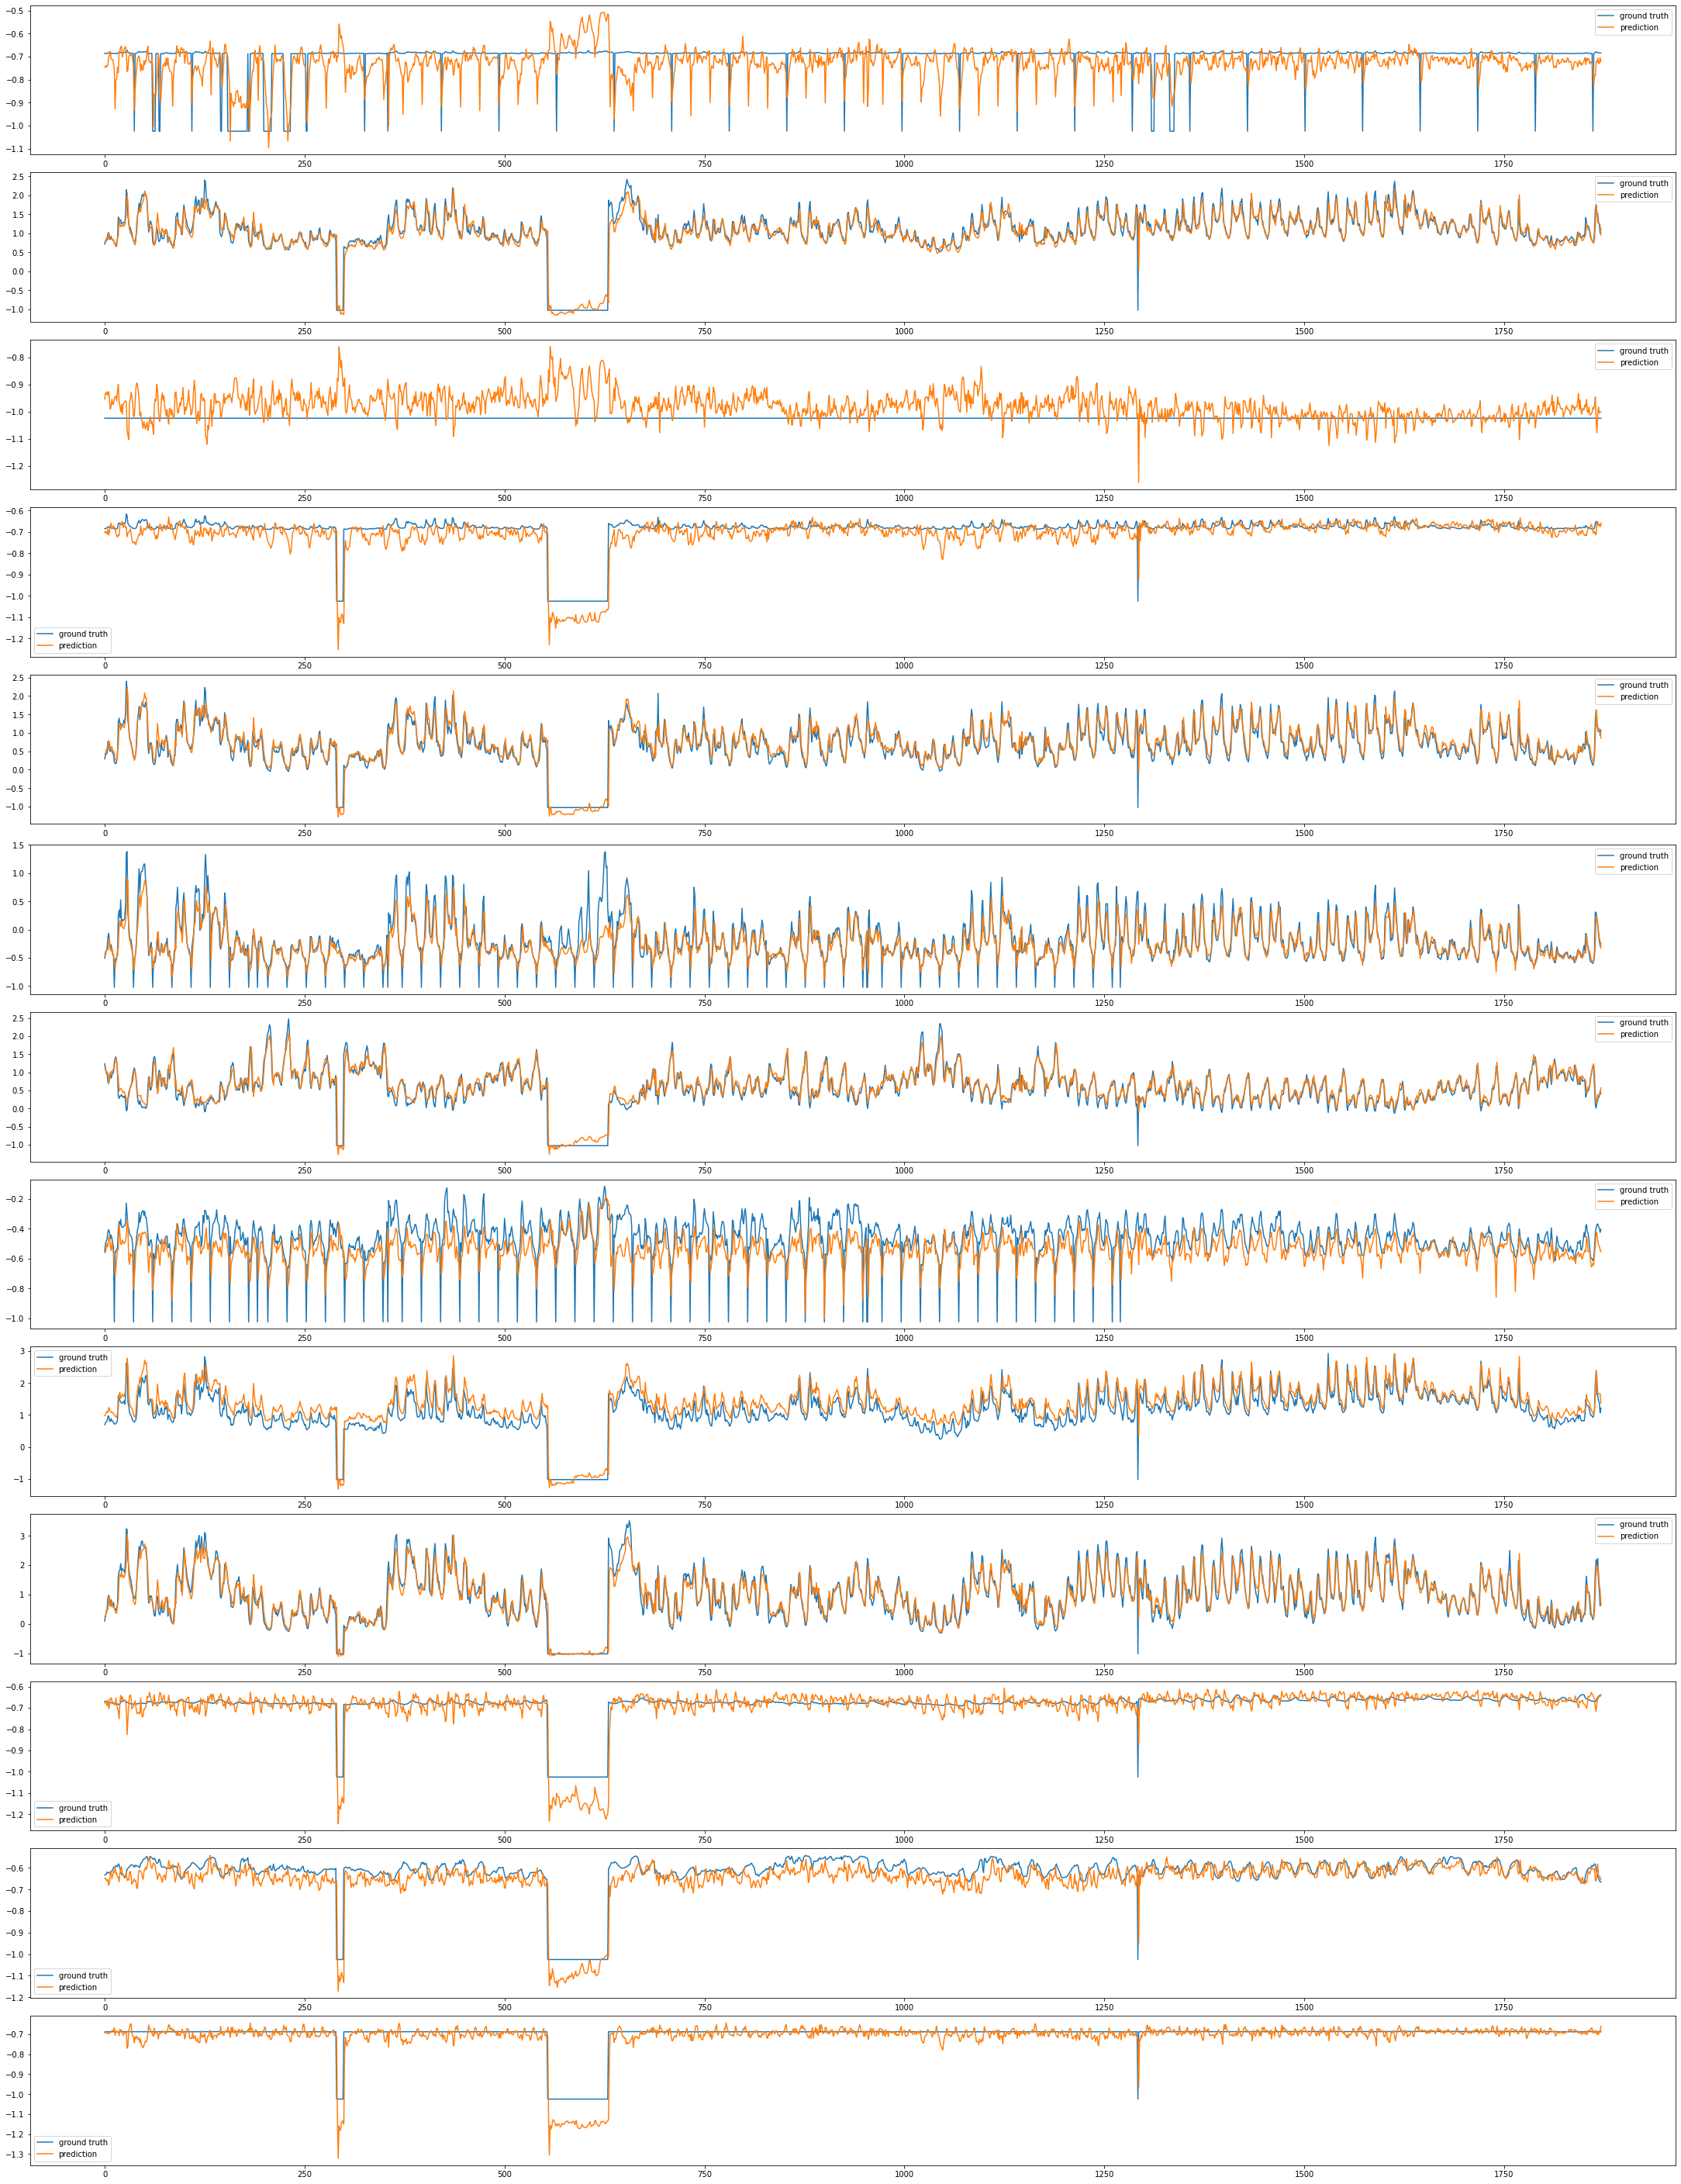

In [140]:
# show prediction and ground truth

assert prd_y.shape == y.shape
nrows = min(y.shape[1],30)
ncols = 1

f = plt.figure(figsize=(30, nrows*3), constrained_layout=True)
ax = f.subplots(nrows, ncols)

for k in range(nrows):
    ax[k].plot(list(range(y.shape[0])), y[:,k], label='ground truth')
    ax[k].plot(list(range(y.shape[0])), prd_y[:,k], label='prediction')
    ax[k].legend()

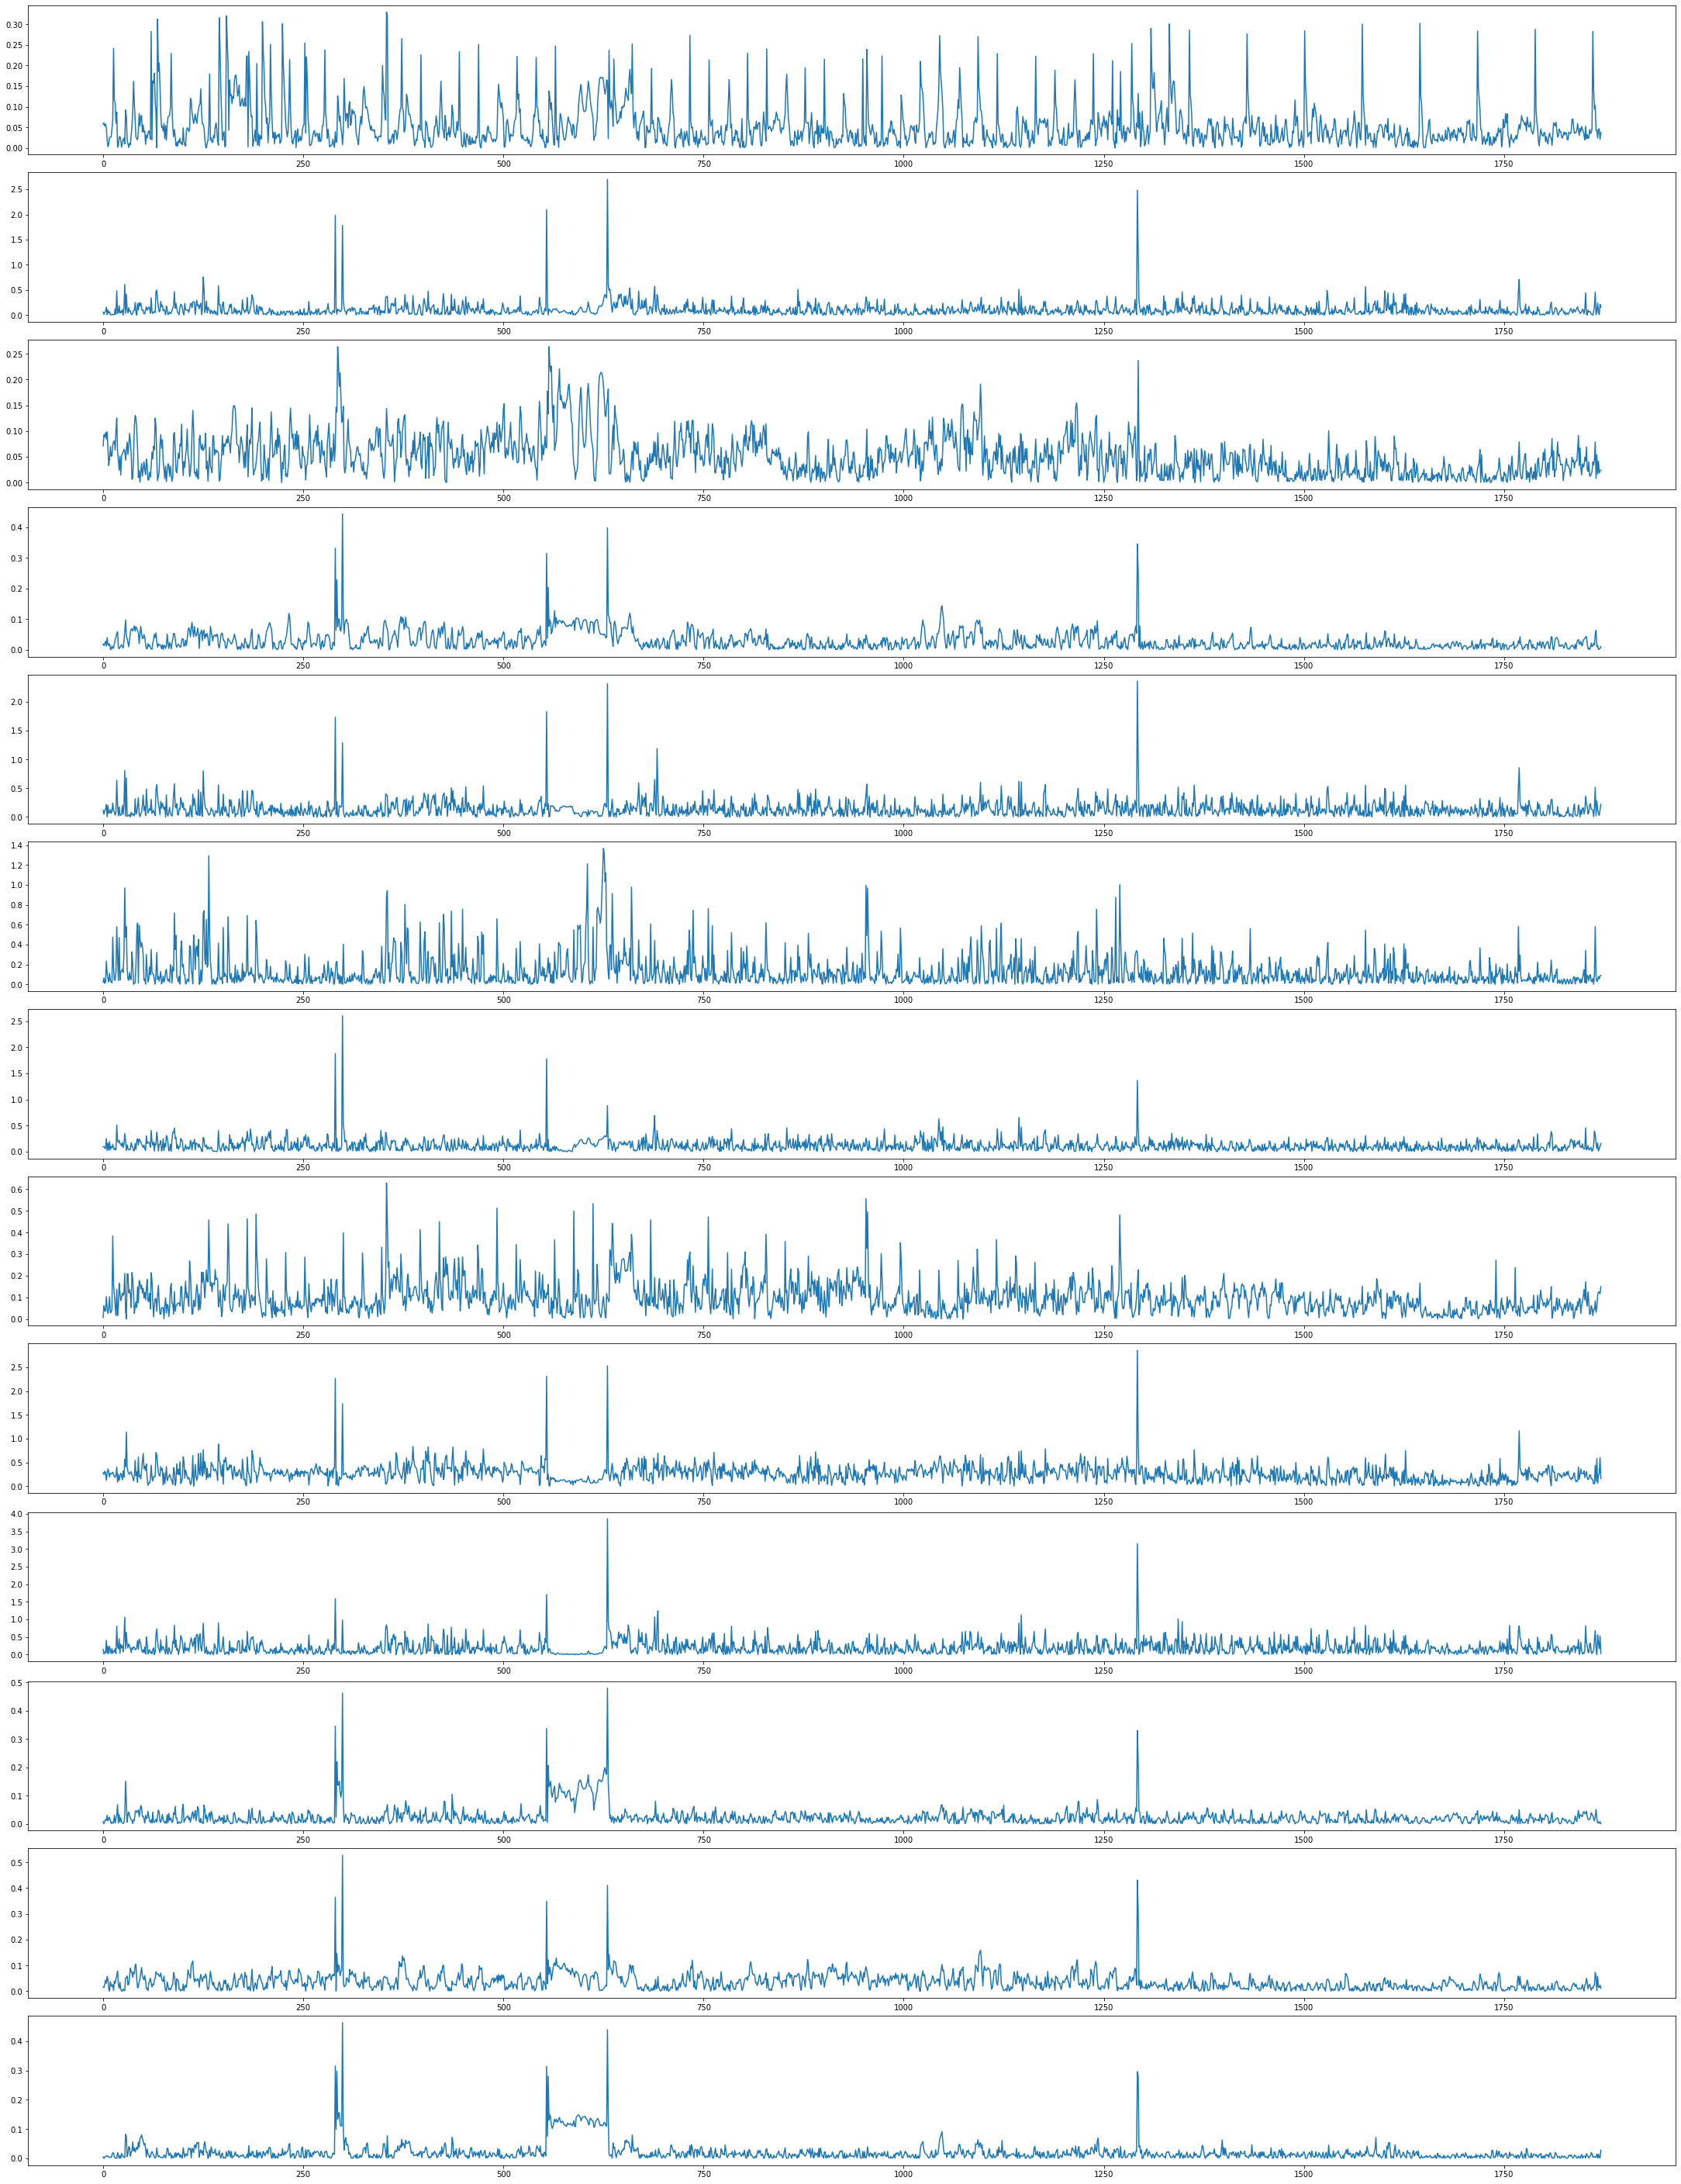

In [141]:
# show error 

f = plt.figure(figsize=(30, nrows*3), constrained_layout=True)
ax = f.subplots(nrows, ncols)

for k in range(nrows):
    ax[k].plot(list(range(y.shape[0])), np.abs(y[:,k] - prd_y[:,k]), label='error')
   

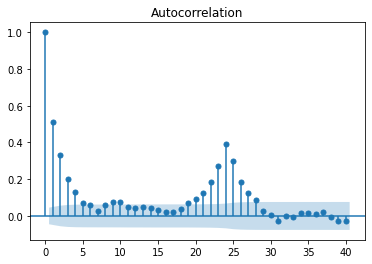

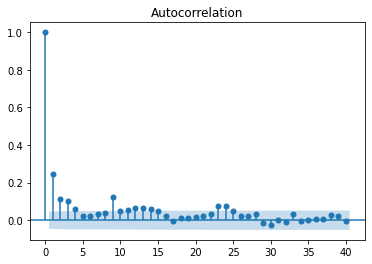

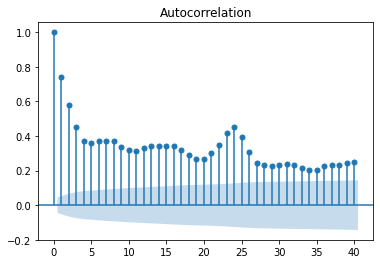

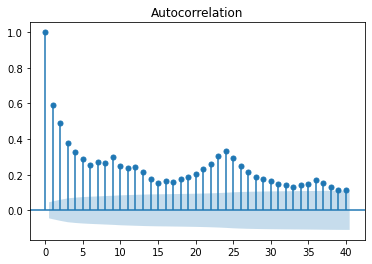

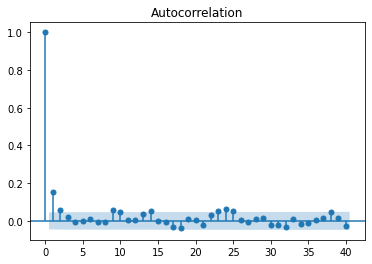

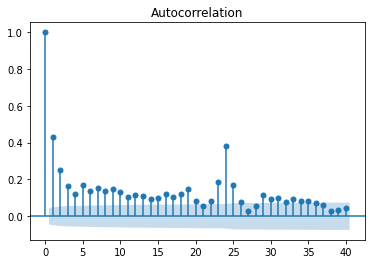

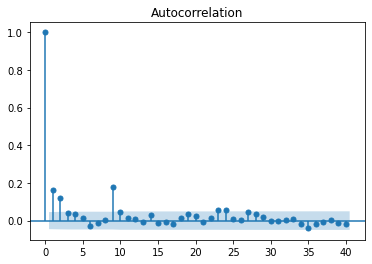

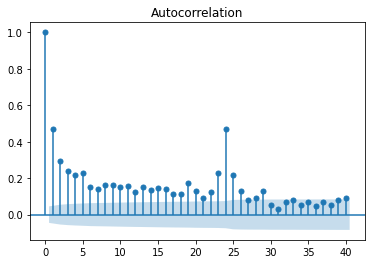

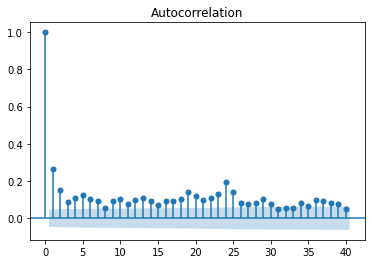

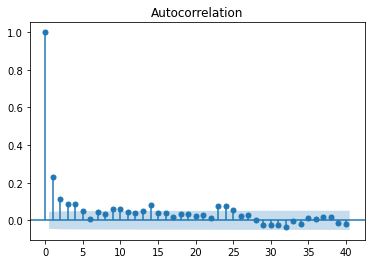

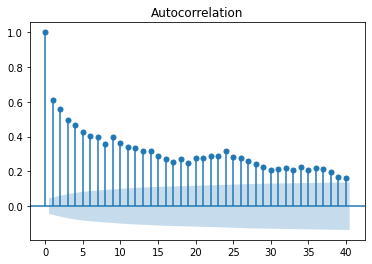

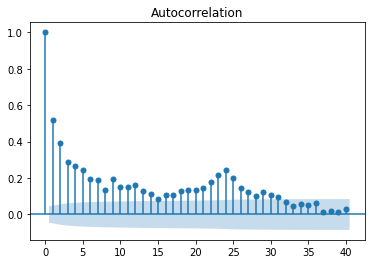

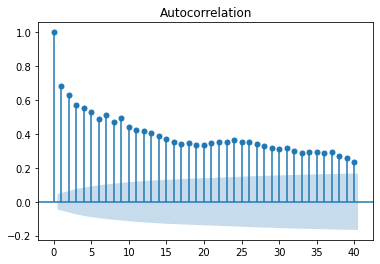

In [143]:
import statsmodels.api as sm
for k in range(nrows):
    sm.graphics.tsa.plot_acf(np.abs(y[:,k] - prd_y[:,k]), lags=40)

In [146]:
model.train()
type(model.parameters())

generator

In [163]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*a**3 - b**2
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad, retain_graph=True)
a.grad


tensor([36., 81.])

In [165]:
a.grad.zero_()
b.grad.zero_()
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad, retain_graph=True)
a.grad

tensor([36., 81.])

In [166]:
self.model.state_dict()['out_proj.bias']
Out[5]: 
tensor([-0.0268, -0.0177, -0.1065, -0.0830,  0.0511,  0.0773,  0.0117,  0.0137,
         0.0736, -0.0401, -0.1160, -0.0357, -0.0720])

NameError: name 'loss' is not defined